Reference : https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial/notebook

In [30]:
%matplotlib inline

import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import scipy

## Loading the files

In [2]:
path = os.getcwd() #Set path = current working directory

In [3]:
def load_scan(path):    
    
    #make a list of slice of CT scan of a patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
    
    #sort the slice in the list according to location
    slices.sort(key = lambda x:float(x.SliceLocation))
    return slices

In [4]:
def get_pixel_hu(slices):
    
    image = np.stack([s.pixel_array for s in slices]) #stack the slices and make a 3D np-array
    image = image.astype(np.int16)
    image[image == -2000] = 0
    
    #Calculate the values in Hounsfield Unit (HU)
    for slice_number in range(len(slices)) :
    
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
    
        if slope != 1 :
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
    
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype = np.int16)
        

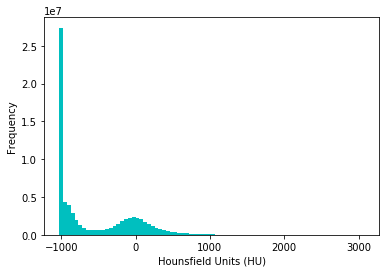

In [5]:
first_patient = load_scan(path + '/' + 'S02A01')
first_patient_pixels = get_pixel_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Frequency')
plt.show()

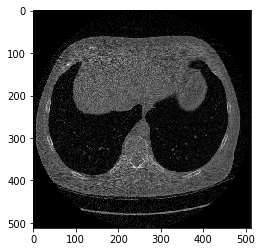

In [6]:
plt.imshow(first_patient_pixels[75], cmap = plt.cm.gray) #75th slice of the CT scan
plt.show()

### Make a GIF of all the slices of a CT scan of a particular patient

In [12]:
first_patient = load_scan(path + '/' + 'S02A01')
first_patient_pixels = get_pixel_hu(first_patient)

from matplotlib.animation import FuncAnimation

def animate(first_patient_pixels, gifname):
    
    fig = plt.figure()
    anim = plt.imshow(first_patient_pixels[0], cmap = plt.cm.bone)

    def update(i):
        anim.set_array(first_patient_pixels[i])
        return anim
    
    a = FuncAnimation(fig, update, frames=range(len(first_patient_pixels)), interval=50)
    a.save(gifname, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


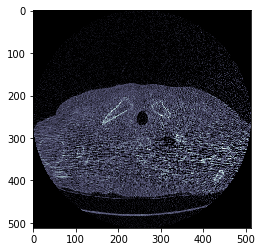

In [8]:
animate(first_patient_pixels, 'ct_scan.gif')
plt.show()

In [9]:
from IPython.display import Image
Image(url='ct_scan.gif')  

## Resampling

In [23]:
np.array(list(map(float, ([first_patient[0].SliceThickness] + list(first_patient[0].PixelSpacing)) )))

array([1.25    , 0.761719, 0.761719])

In [25]:
spacing = np.array([first_patient[0].SliceThickness] + list(first_patient[0].PixelSpacing))

In [27]:
print(spacing/[1,1,1])

[1.25     0.761719 0.761719]


In [28]:
def resample(image, scan, new_spacing=[1, 1, 1]):
    
    spacing = np.array([first_patient[0].SliceThickness] + list(first_patient[0].PixelSpacing))
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [31]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

AttributeError: module 'scipy' has no attribute 'ndimage'